In [186]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [187]:
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

In [188]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return np.abs(1/(factor*10**-6*der))

In [403]:
omega_c1 = 4*2*np.pi
g_int1 = 0.15*2*np.pi
omega_c2 = 5*2*np.pi
g_int2 = 0.075*2*np.pi

In [404]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)
    
    return Hs,-1j*(s-sd),phi_zpf,c2,c3
from qutip import propagator,floquet_modes,Qobj,Options,basis
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def energy_diff2(phi_ex):
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    H0,v,phi_zpf,c2,c4 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    Hs,charge_op = snail.spectrum_charge()
    omegas = H0[1][1]-H0[0,0]
    
    #cavity1 parameters
#     omega_c1 = 7*2*np.pi
#     g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
#     omega_c2 = 3*2*np.pi
#     g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()
    
    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2

    energy,U = np.linalg.eigh(H)
    energy,U = sort(energy,U,H)
    energy = energy - energy[0]*np.ones(len(energy))
    omegas = snail.omegas
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    energys1 = energy[indexs1]
    indexs2 = np.argmin(np.abs(energy - (2*omegas ) * np.ones(len(energy))))
    anh = energy[indexs2] - 2*energys1
    
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    energyc11 = energy[indexc11]
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    energyc12 = energy[indexc12]
    indexsc11 = np.argmin(np.abs(energy - (energys1+energyc11) * np.ones(len(energy))))
    energysc11 = energy[indexsc11]
    starkshift11 = energysc11  - energyc11 - energys1
    selfkerr1 = energyc12 - 2*energyc11
    
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    energyc21 = energy[indexc21]
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    energyc22 = energy[indexc22]
    indexsc21 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    energysc21 = energy[indexsc21]
    indexsc22 = np.argmin(np.abs(energy - (omegas+2*omega_c2) * np.ones(len(energy))))
    energysc22 = energy[indexsc22]
    
    starkshift21 = energysc21  - energyc21 - energys1
    selfkerr2 = energyc22 - 2*energyc21
    starkshift22 = energysc22  - 2*energyc21 - energys1 - 2*starkshift21 - 2*selfkerr2
    
    index12 = np.argmin(np.abs(energy - energyc11* np.ones(len(energy)) - energyc21 * np.ones(len(energy))))
    energy12 = energy[index12]
    index121 = np.argmin(np.abs(energy - (omega_c2+omega_c1+omegas) * np.ones(len(energy))))
    energy121 = energy[index121]
    crosskerr = energy12 - energyc11 - energyc21
    scrosskerr = energy121 - energyc11 - energyc21 - energys1 - starkshift11 - starkshift21
#     g = (cavity1.g_int * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)/2/phi_zpf)
#     energyc11 = g**2/(omega_c1-omegas)
#     energyc21 = g**2/(omega_c2-omegas)
    return crosskerr, energyc11, energyc21,  starkshift11, starkshift21, selfkerr1, selfkerr2,anh,energys1,c4[0]
#     return energys1,anh,energyc11,selfkerr1, starkshift11,starkshift12,energyc21,selfkerr2, starkshift21,starkshift22,crosskerr,scrosskerr

In [405]:
energy_diff2(0.401)

7.986528518964835 3.9932642344341


(3.290429582136767e-07,
 25.090419165482075,
 31.397289763961556,
 3.560856929851752e-05,
 2.902503212709462e-05,
 3.1476644579697677e-07,
 1.0592307830847858e-07,
 0.0016159233625359093,
 37.985288863055594,
 0.0839294959576793)

In [406]:
fluxs = np.linspace(0.39, 0.43, 100)
result = Parallel(n_jobs=-1)(delayed(energy_diff2)(flux) for flux in fluxs)
result = np.array(result)
result1 = Parallel(n_jobs=-1)(delayed(energy_diff2)(flux+1e-5) for flux in fluxs)
result1 = np.array(result1)
der1 = (result1[:,1] - result[:,1])/1e-5
der2 = (result1[:,2] - result[:,2])/1e-5

In [407]:
result1[:,1]-result[:,1]

array([-8.15513406e-07, -8.17502002e-07, -8.19482970e-07, -8.21456116e-07,
       -8.23420823e-07, -8.25377139e-07, -8.27324829e-07, -8.29263719e-07,
       -8.31193095e-07, -8.33113145e-07, -8.35023325e-07, -8.36923945e-07,
       -8.38814103e-07, -8.40693748e-07, -8.42562280e-07, -8.44420235e-07,
       -8.46266868e-07, -8.48101600e-07, -8.49924646e-07, -8.51735503e-07,
       -8.53533827e-07, -8.55319339e-07, -8.57091973e-07, -8.58851084e-07,
       -8.60596629e-07, -8.62328097e-07, -8.64045695e-07, -8.65748323e-07,
       -8.67436253e-07, -8.69108849e-07, -8.70766154e-07, -8.72407362e-07,
       -8.74032597e-07, -8.75641220e-07, -8.77233006e-07, -8.78807576e-07,
       -8.80364574e-07, -8.81903908e-07, -8.83424921e-07, -8.84927523e-07,
       -8.86411058e-07, -8.87875476e-07, -8.89320003e-07, -8.90744644e-07,
       -8.92149014e-07, -8.93532800e-07, -8.94895198e-07, -8.96236404e-07,
       -8.97555523e-07, -8.98852395e-07, -9.00126963e-07, -9.01378527e-07,
       -9.02606157e-07, -

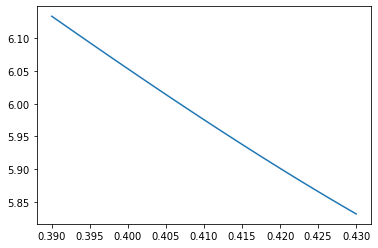

In [408]:
plt.plot(fluxs,result[:,-2]/2/np.pi)

In [409]:
def app(phi_ex):
    EJ = 95*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    H0,v,phi_zpf,c2,c4 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    g3 = snail.g3
    g4 = snail.g4
    omega_s = H0[1][1]-H0[0,0]
    g1 = (g_int1 * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)/2/phi_zpf)
    g2 = (g_int2 * 2 * ((2 * snail.EC/ snail.EJ) ** 0.25)/2/phi_zpf)
    energyc11 = omega_c1 + g1**2/(omega_c1-omega_s)
    energyc21 = omega_c2 + g2**2/(omega_c2-omega_s)
    
    omegap = 1/((8*omega_c1**2-3*omega_s**2)/(omega_s*(2*omega_c1-omega_s)*(omega_s+2*omega_c1)))
    selfkerr1 =(12*g4 - 36*g3**2/omega_s*(omega_s/omegap))*(g1/(omega_s-omega_c1))**4
    omegap = 1/((omega_c1**2-6*omega_s**2)/(omega_s*(omega_c1-2*omega_s)*(2*omega_s+omega_c1)))
    ratio = omega_s/omegap
    print(ratio)
    starkshift11 = 24*(g4-3*g3**2/omega_s*omega_s/omegap)*(g1/(omega_s-omega_c1))**2
    
    omegap = 1/((8*omega_c2**2-3*omega_s**2)/(omega_s*(2*omega_c2-omega_s)*(omega_s+2*omega_c2)))
    selfkerr2 =(12*g4 - 36*g3**2/omega_s*(omega_s/omegap))*(g2/(omega_s-omega_c2))**4
    omegap = 1/((omega_c2**2-6*omega_s**2)/(omega_s*(omega_c2-2*omega_s)*(2*omega_s+omega_c2)))
    ratio = omega_s/omegap
    print(ratio)
    starkshift21 = 24*(g4-3*g3**2/omega_s*omega_s/omegap)*(g2/(omega_s-omega_c2))**2
    omegap =1/(1/(omega_c1-omega_c2-omega_s)+1/(-omega_c1+omega_c2-omega_s)+1/(omega_c1+omega_c2-omega_s)+1/(-omega_c1-omega_c2-omega_s)-2/omega_s)
    crosskerr = (24*g4-72*g3**2/omega_s*(-omega_s/omegap)/2)*(g1/(omega_s-omega_c1))**2*(g2/(omega_s-omega_c2))**2
    return crosskerr, energyc11, energyc21,  starkshift11, starkshift21, selfkerr1, selfkerr2,np.array([g4-3*ratio*g3**2/omega_s])

In [410]:
app(0.4117)

1.567500901077433
1.6141375974418977


(array([1.79291848e-06]),
 array([25.09345151]),
 array([31.39381181]),
 array([0.00022214]),
 array([0.00023723]),
 array([1.26477367e-06]),
 array([7.75132487e-07]),
 array([0.00224406]))

In [411]:
def coeff(omega_s,omega_c1,omega_c2):

    omegap = 1/(1/(omega_c1-omega_c2-omega_s)+1/(-omega_c1+omega_c2-omega_s)+1/(omega_c1+omega_c2-omega_s)+1/(-omega_c1-omega_c2-omega_s)-2/omega_s)
    ck = (-omega_s/omegap)/2
    omegap =1/((8*omega_c1**2-3*omega_s**2)/(omega_s*(2*omega_c1-omega_s)*(omega_s+2*omega_c1)))
    sk1 = omega_s/omegap 
    omegap = 1/((8*omega_c2**2-3*omega_s**2)/(omega_s*(2*omega_c2-omega_s)*(omega_s+2*omega_c2)))
    sk2 = omega_s/omegap
    omegap = 1/((omega_c1**2-6*omega_s**2)/(omega_s*(omega_c1-2*omega_s)*(2*omega_s+omega_c1)))
    ss1 = omega_s/omegap 
    omegap = 1/((omega_c2**2-6*omega_s**2)/(omega_s*(omega_c2-2*omega_s)*(2*omega_s+omega_c2)))
    ss2 = omega_s/omegap 
    c1 = omega_c1/omega_s*(1/(omega_c1-omega_s)**2)
    print(1/(omega_c1-omega_s)**2)
    c2 = omega_c2/omega_s*(1/(omega_c2-omega_s)**2)
    print(1/(omega_c2-omega_s)**2)
    return ck,sk1,sk2,ss1,ss2,c1,c2

In [412]:
coeff(6,5,4)

1.0
0.25


(1.2285714285714286,
 1.4375,
 0.7142857142857143,
 1.6050420168067225,
 1.5625,
 0.8333333333333334,
 0.16666666666666666)

In [413]:
result_app = Parallel(n_jobs=-1)(delayed(app)(flux) for flux in fluxs)
result_app = np.array(result_app)

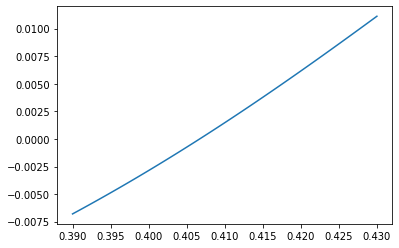

In [414]:
plt.plot(fluxs,result_app[:,-1])

(-1e-07, 1e-07)

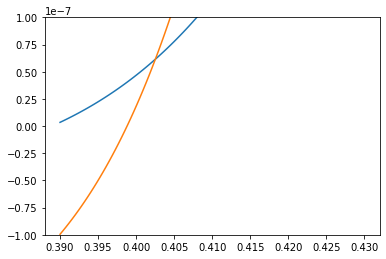

In [415]:
plt.plot(fluxs,result[:,0]/2/np.pi)
plt.plot(fluxs,result_app[:,0]/2/np.pi)
plt.ylim(-1e-7,1e-7)

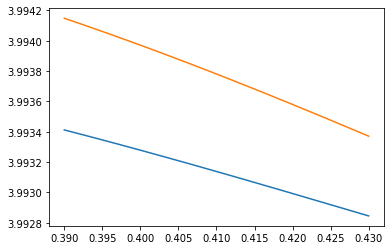

In [416]:
plt.plot(fluxs,result[:,1]/2/np.pi)
plt.plot(fluxs,result_app[:,1]/2/np.pi)
# plt.ylim(-1e-4,1e-4)

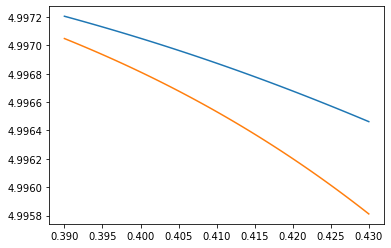

In [417]:
plt.plot(fluxs,result[:,2]/2/np.pi)
plt.plot(fluxs,result_app[:,2]/2/np.pi)
# plt.ylim(-1e-6,1e-6)

(-1.0, 1.0)

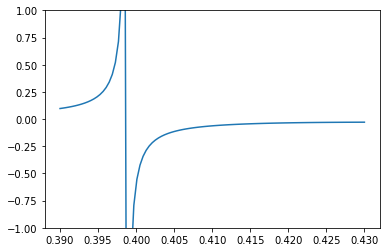

7.986657569916501 3.993328764720411
7.986424304023725 3.9932121225694455
7.986613626487754 3.993306791443283
7.986309759737019 3.993154845032506
1.5653033013860242
1.6101270239293692
1.5666055010665902
1.612500923331624
7.986525455155359 3.9932627024068528
7.984354742301254 3.9921771083495647
7.9868073747660855 3.9934036719229358
7.986327300057129 3.993163616058344
7.986514023869298 3.9932569863032485
7.986309759737019 3.993154845032506
7.986679264119501 3.9933396125656793
7.986732811936766 3.993366388233713
7.986463561178657 3.9932317528577554
7.98670086222124 3.9933504123391463
7.989692881008219 3.9948464393389043
7.989556252972838 3.9947781252045482
7.98651430022726 3.9932571244934087
7.986764806218096 3.9933823863748508
7.986332758865007 3.9931663457287607
1.5654326303777333
1.6103624538196115
1.5670872168176078
1.6133809934818109
12.03131623884673 5.9076065644326965
12.109363416153192 5.934461732784931
12.013058068354523 5.899232189979408
1.6719066308408648
1.7671522574498775
14.0

7.986706246601279 3.9933531047065647
7.9866573008535395 3.993328630179595
1.5644895282574187
1.608647329830299
7.98670086222124 3.9933504123391463
7.986367406398191 3.9931836711537514
7.984343136651694 3.9921713031355477
7.984353923261707 3.99217669866169
7.986646687134664 3.9933233229495375
7.986292750716459 3.993146339668572
7.986569582354815 3.9932847677331824
7.986355686889707 3.993177810844854
7.986624850956878 3.9933124040842802
7.986807114246723 3.9934035416556477
7.986770379484554 3.993385173178568
7.989745125789211 3.9948725619793106
7.98667384953423 3.993336905089098
7.986475089968647 3.993237517742274
7.986597152707162 3.9932985539474024
1.563476276262694
1.6068089988700267
12.091920092430026 5.929577804951243
11.99215306602669 6.101336666199775
12.071374190411689 5.92306006240246
1.6698942368896632
1.7635874852423714
1.6790953206458443
1.7799835578765715
14.018471972003194 7.010711701800049
14.019940308055485 7.009969747708314
14.018393877201829 7.01071063665507
14.02016479

7.986497527580424 3.9932487374843206
7.98638452584478 3.9931922316758235
7.986586141567761 3.993293047966802
7.986367123574587 3.993183529728642
1.56495949956479
1.6095015280949394
7.986575381090794 3.9932876673220705
7.984349004038344 3.9921742380387006
7.984358308207154 3.992178892033502
7.986525455155359 3.9932627024068528
7.986780719053693 3.9933903432765008
7.986372834971861 3.9931863856953296
7.986525455155359 3.9932627024068528
7.9867435015405785 3.993371733374032
7.986355686889707 3.993177810844854
7.986553247129125 3.993276599490608
7.989752028975611 3.9948760136252393
7.986802108724492 3.993401038747992
7.9867435015405785 3.993371733374032
7.986469189062951 3.993234567039627
1.5641075233825723
1.6079537325210789
1.5660389150809402
1.6114671183201643
12.054342036684647 5.9169590216873535
12.06357357024691 5.920348251951538
1.6708296587812062
1.765243029502919
14.023538971391043 7.011770341673827
14.020359358627877 7.010179382586578
14.021994606363899 7.01099752433179
14.001102

7.986780981140922 3.993390474327995
7.986469467509206 3.9932347062745555
7.986722097650856 3.993361030747293
7.986389941003284 3.9931949395049156
1.5650453006548655
1.6096575814198335
1.5665181298278865
1.6123414109873127
7.986531024494713 3.9932654872989155
7.986327300057129 3.993163616058344
7.98434345967404 3.992171464713429
7.984357373322662 3.992178424399762
7.9865698559930625 3.993284904562729
7.98638452584478 3.9931922316758235
7.986597152707162 3.9932985539474024
7.9864466467867645 3.993223294933054
7.986635780763829 3.99331786937869
7.9866573008535395 3.993328630179595
7.986286691696706 3.9931433098512183
7.986564325285276 3.993282138996969
7.989704222667093 3.9948521102057453
7.989498951221638 3.994749474373607
7.986531024494713 3.9932654872989155
7.986350245172103 3.9931750897263196
7.986519604300134 3.9932597767442064
1.5642770143025246
1.6082613939079031
1.5668680239125792
1.612980411314516
12.03742301294745 5.910215835957165
11.975822070874456 6.093282317676748
12.0682491

11.999545010516277 6.1052123031982815
1.67367417392927
1.7702930722062207
14.023085478995071 7.0115433932837945
14.024006293014716 7.012004225285096
14.010518303750887 7.010604091834484
13.982389642674418 7.010237139019027
16.009973753789016 8.004986886536964
16.0105679733959 8.005284058023902
16.00960662299811 8.00480328714889
1.923500205545221
1.770536580450959
1.9427964829545668
1.7807444915701534
16.009876555154563 8.004938277921848
16.010650176075522 8.005325168571439
1.9057595452596214
1.7610147096934772
1.9672002913942221
1.793437393779969
7.986292750716459 3.993146339668569
7.98681237423634 3.9934061718034917
7.985880550982087 3.992940214483975
1.5679671842352974
1.6149913158080074
7.986749100994832 3.993374533276778
7.986463839880101 3.993231892220384
7.986547424986099 3.9932736881919784
7.986327015664674 3.993163473848207
1.5648310026748515
1.6092678812702244
1.5662564509356018
1.6118638705162447
7.986684672698175 3.9933423170376496
7.98631004477695 3.9931549875666925
7.98434

7.986608412647411 3.9933041843326307
7.986695204781128 3.9933475834315133
7.986457928153004 3.9932289361036304
1.564745470982493
1.609112398764163
7.986608412647411 3.9933041843326307
7.984348417846519 3.9921739448221136
7.984360264620458 3.9921798706406024
7.986635780763829 3.99331786937869
7.986424304023725 3.9932121225694455
7.986640966948359 3.993320462654816
7.9866954717661445 3.993347716932924
7.986458207108308 3.993229075593275
7.986738159831618 3.9933690623509666
7.98629823419094 3.993149081682522
7.98651430022726 3.9932571244934087
7.98627541882822 3.993137672840125
7.989560397328398 3.9947801973805213
7.989534976775509 3.994767487118572
7.986646687134664 3.9933233229495375
7.986705980217629 3.9933529715059817
1.5633091452635517
1.6065062086376767
1.5664744735032476
1.6122617209963501
12.05588949239841 5.9175410867797975
11.97730167390025 6.09398317419682
12.028196362718612 5.906236760502286
11.98167294638358 6.096087337346739
1.6762942207755582
1.7749656388013417
1.6785318020

7.986613897870474 3.993306927144537
7.986315800892262 3.993157865909979
7.986558514798419 3.9932792335295257
7.986332758865007 3.9931663457287607
1.5647882188178455
1.6091901032421805
7.986780981140922 3.993390474327995
7.98627541882822 3.993137672840125
7.984344164322244 3.992171817183002
7.986812634440211 3.993406301912976
7.9866573008535395 3.993328630179595
7.986452290013208 3.9932261167908267
7.986613897870474 3.993306927144537
7.986441278210184 3.9932206104107992
7.986673581356561 3.9933367709911463
7.986727723042487 3.993363843623966
7.989722980670553 3.9948614892872363
7.989450298283759 3.9947251479646466
7.986542146803777 3.99327104889373
7.98631004477695 3.9931549875666925
7.986651862127374 3.993325910627126
7.986384243717494 3.993192090599122
1.5645321128934306
1.608724689581133
1.5659086364994592
1.6112296104920378
12.077721171674924 5.925167667942739
12.09660232491098 5.930944257174758
12.001041597293877 6.106014288690059
1.6757391723981632
1.7739740799214605
1.67839117536

7.986635780763829 3.99331786937869
7.986673581356561 3.9933367709911463
1.5643194583509044
1.6083384585148137
1.5664744735032476
1.6122617209963501
7.98667384953423 3.993336905089098
7.984374415480914 3.9921869489542097
7.98436341539261 3.992181446670643
7.986519880391417 3.9932599148009693
7.98680184789025 3.9934009083232263
7.986389941003284 3.9931949395049156
7.986531024494713 3.9932654872989155
7.986361690589107 3.993180812979488
7.986558514798419 3.9932792335295257
7.986338497621005 3.9931692153853287
7.986597424943576 3.993298690075703
7.989756500960592 3.9948782496555593
7.9868073747660855 3.9934036719229358
7.986817627846549 3.9934087987604823
7.986429686866721 3.993214814229602
1.5643194583509044
1.6083384585148137
1.5658218892854012
1.6110715053795255
12.076151393944091 5.924654473903145
11.969913168300291 6.090540551960619
12.020610103556235 5.902801115625908
11.975748855569806 6.093247786249004
1.6758777663283937
1.7742215839232538
1.6779699080425825
1.7779646824254256
14.0

7.986564325285276 3.993282138996969
7.986738159831618 3.9933690623509666
1.5642770143025246
1.6082613939079031
1.5663000189661749
1.6119433571765864
7.986646687134664 3.9933233229495375
7.98638452584478 3.9931922316758235
7.984343459674035 3.9921714647134294
7.986690075252798 3.993345018496227
7.986407285320709 3.99320361245484
7.986536313101417 3.9932681318122767
7.98629823419094 3.993149081682522
7.9864919260636675 3.9932459364942807
7.986684405115098 3.993342183237084
7.9864353451853445 3.9932176436383475
7.986613897870474 3.993306927144537
7.989709722207679 3.9948548599969125
7.986770379484554 3.993385173178568
7.986286977575703 3.9931434528052705
7.9864804292998945 3.9932401876326433
1.5644469658761517
1.6085700184931104
12.099862509731258 5.931871154247191
12.001115708911934 6.106054154198102
12.037347296251768 5.910184063112281
11.993570188543305 6.102068612262994
1.6740850224006942
1.771024438286064
1.677409648826967
1.776961037913023
14.024008924036737 7.01200554209292
14.0011

In [425]:
plt.plot(fluxs,der1/result[:,3]/2/np.pi/(der2/result[:,4]/2/np.pi)-1*np.ones(100))
plt.ylim(-1,1)

In [420]:
der2

array([-0.09188601, -0.09235267, -0.09282122, -0.09329161, -0.09376378,
       -0.09423778, -0.09471357, -0.09519116, -0.09567047, -0.09615157,
       -0.09663437, -0.09711888, -0.09760507, -0.09809294, -0.09858247,
       -0.09907362, -0.09956641, -0.10006071, -0.10055663, -0.10105403,
       -0.10155301, -0.10205343, -0.10255532, -0.10305863, -0.10356335,
       -0.10406946, -0.10457686, -0.10508561, -0.10559563, -0.1061069 ,
       -0.10661937, -0.10713301, -0.10764775, -0.10816361, -0.10868059,
       -0.10919852, -0.10971744, -0.11023729, -0.11075803, -0.11127966,
       -0.11180206, -0.11232519, -0.11284905, -0.11337356, -0.11389867,
       -0.11442438, -0.11495053, -0.11547713, -0.11600413, -0.11653147,
       -0.11705906, -0.11758687, -0.11811485, -0.1186429 , -0.11917092,
       -0.11969897, -0.1202269 , -0.1207546 , -0.12128204, -0.12180918,
       -0.12233589, -0.12286212, -0.12338785, -0.12391288, -0.12443723,
       -0.12496079, -0.12548342, -0.12600509, -0.12652571, -0.12

(-2e-05, 2e-05)

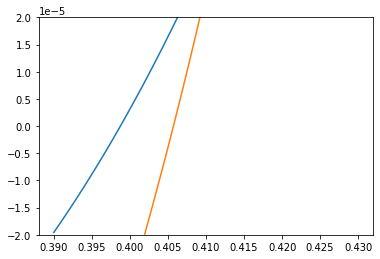

In [421]:
plt.plot(fluxs,result[:,3]/2/np.pi)
plt.plot(fluxs,result_app[:,3]/2/np.pi)
plt.ylim(-2e-5,2e-5)

(-2e-05, 2e-05)

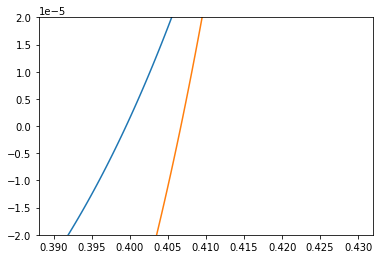

In [422]:
plt.plot(fluxs,result[:,4]/2/np.pi)
plt.plot(fluxs,result_app[:,4]/2/np.pi)
plt.ylim(-2e-5,2e-5)

(-1e-07, 1e-07)

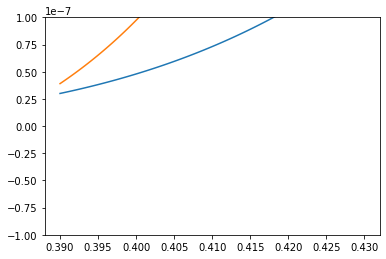

In [423]:
plt.plot(fluxs,result[:,5]/2/np.pi)
plt.plot(fluxs,result_app[:,5]/2/np.pi)
plt.ylim(-1e-7,1e-7)

(-1e-07, 1e-07)

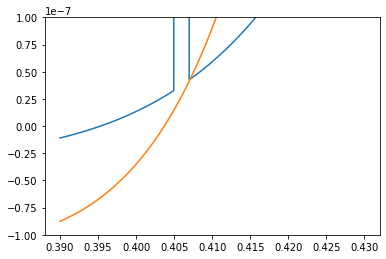

In [424]:
plt.plot(fluxs,result[:,6]/2/np.pi)
plt.plot(fluxs,result_app[:,6]/2/np.pi)
plt.ylim(-1e-7,1e-7)